# Zillow Report: Predicting property tax assessed values of single family properties with a transaction during 2017

Goal: Find drivers for assessed tax value of single family homes with a transaction during 2017, using regression models.

### Imports

In [37]:
# standard imports
import pandas as pd
import numpy as np
# models
import wrangle
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# stats
from scipy import stats
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

###  Acquire and Prep

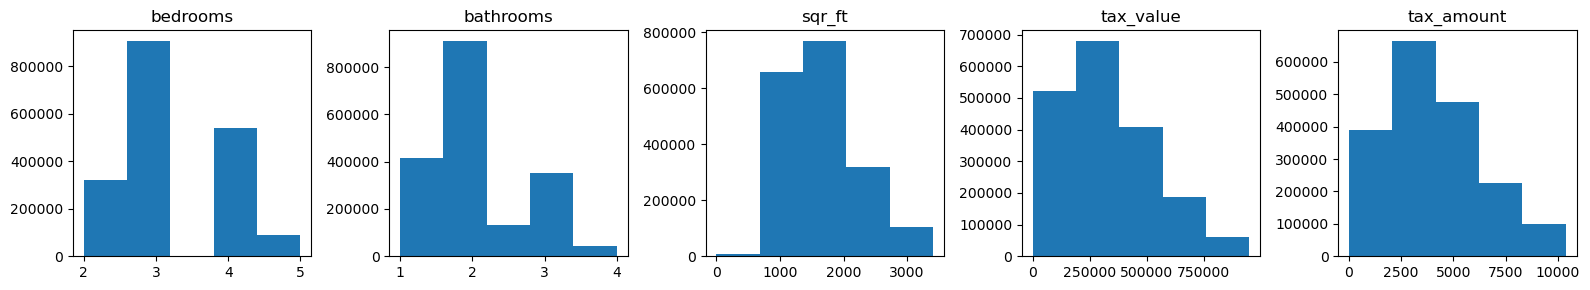

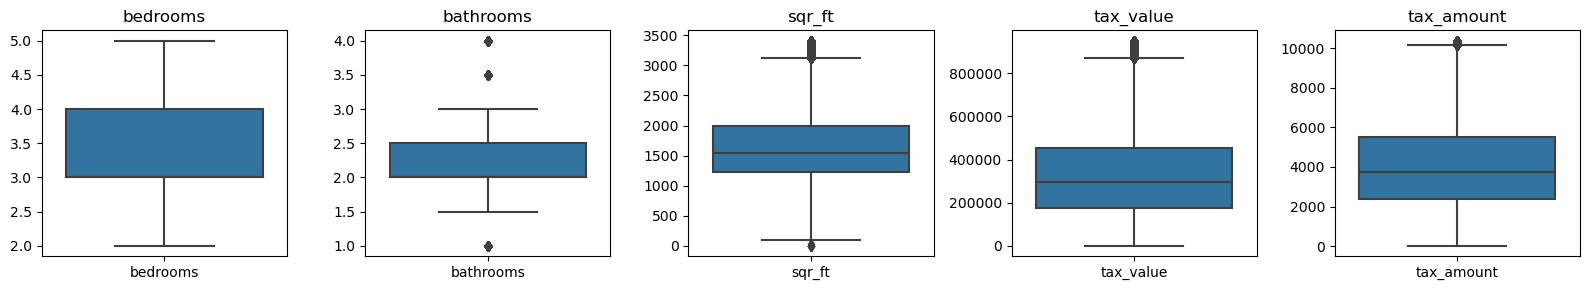

In [2]:
train, validate, test = wrangle.wrangle_zillow()

In [3]:
# inital glace at data
print('_'*50)
print(f'Data Frame: \n{train.sort_index().head(2).T.to_markdown()}')
print('_'*50)
print(f'Stats: \n{train.describe().T}')
print('_'*50)
print('Info: ')
print(train.info())
print('_'*50)
print(f'Data Types: \n{train.dtypes}')
print('_'*50)
print(f'Null Values: \n{train.isnull().sum()}')
print('_'*50)
print(f'NA Values: \n{train.isna().sum()}')
print('_'*50)
print(f'Unique Value Count: \n{train.nunique()}')

__________________________________________________
Data Frame: 
|            |        6 |        18 |
|:-----------|---------:|----------:|
| bedrooms   |      3   |      3    |
| bathrooms  |      4   |      1    |
| sqr_ft     |   1620   |   1244    |
| tax_value  | 847770   | 169471    |
| year_built |   2011   |   1950    |
| tax_amount |  10244.9 |   2532.88 |
| fips       |   6037   |   6037    |
| zipcode    |  96047   |  96201    |
__________________________________________________
Stats: 
                count           mean            std      min        25%  \
bedrooms    1038959.0       3.214004       0.781049     2.00       3.00   
bathrooms   1038959.0       2.053663       0.707839     1.00       2.00   
sqr_ft      1038959.0    1653.719097     564.247247     1.00    1232.00   
tax_value   1038959.0  327962.928757  198987.574520    22.00  173843.50   
year_built  1038959.0    1959.442489      20.533503  1812.00    1949.00   
tax_amount  1038959.0    4069.177134    2242.51

Less than 1% of the zipcode data are null values. Because I need to report the location of property tax values, I will drop these values and return to them if time alots. Worth noting the original dataset did have other location identifiers such as latittude and longitude that could be used to dissect the location of properties with null zipcode values.

### Exploration

In [4]:
corr = train.corr()
corr

,bedrooms,bathrooms,sqr_ft,tax_value,year_built,tax_amount
bedrooms,1.000000,0.580249,0.593592,0.200161,0.364570,0.199798
bathrooms,0.580249,1.000000,0.762476,0.354842,0.532318,0.354405
sqr_ft,0.593592,0.762476,1.000000,0.423012,0.464196,0.417093
tax_value,0.200161,0.354842,0.423012,1.000000,0.249055,0.969866
year_built,0.364570,0.532318,0.464196,0.249055,1.000000,0.252396
tax_amount,0.199798,0.354405,0.417093,0.969866,0.252396,1.000000


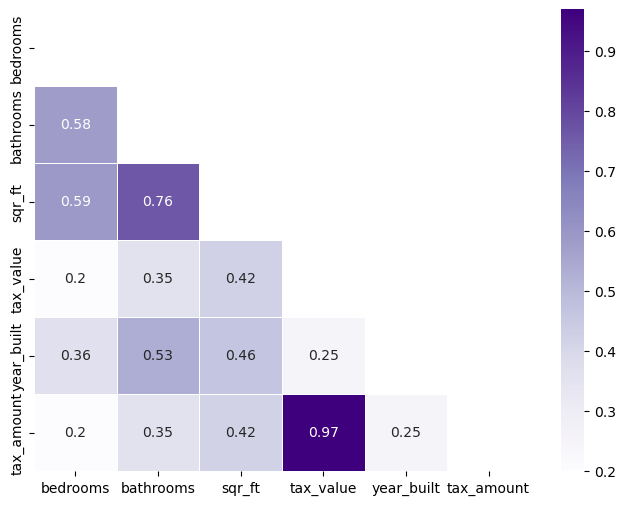

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='Purples', annot=True, linewidths=0.5, mask=np.triu(corr))
plt.ylim
plt.show()

Tax amount has the strongest correlation, and most obvious correlation with tax value at .97.

It looks like there is a strong correlation between sqr_ft and bathrooms.

Another semi-strong correlation is:
- bedrooms and sqr_ft
- bedrooms and bathrooms

bathrooms and year_built is the last correlation with a correlation score greater than .5

<Figure size 1500x1500 with 0 Axes>

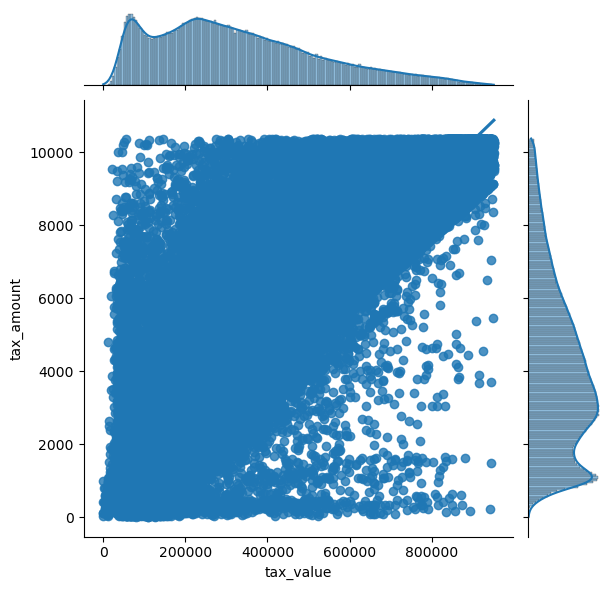

In [6]:
# tax amount x tax value
plt.figure(figsize=(15,15))
sns.jointplot(x="tax_value", y="tax_amount", data=train,  kind='reg')
plt.show()

tax_value x tax_amount produces a bimodal distribution for both variables. The bimodal distribution indicates 2 distinct groups. There are 4 peak intersections between the distributions:
- (tax_value, tax_amount)
- (~100,000, 1000)
- (~250,000, 1000)
- (~100,000 , 3,000)
- (~250,000 , 3,000)

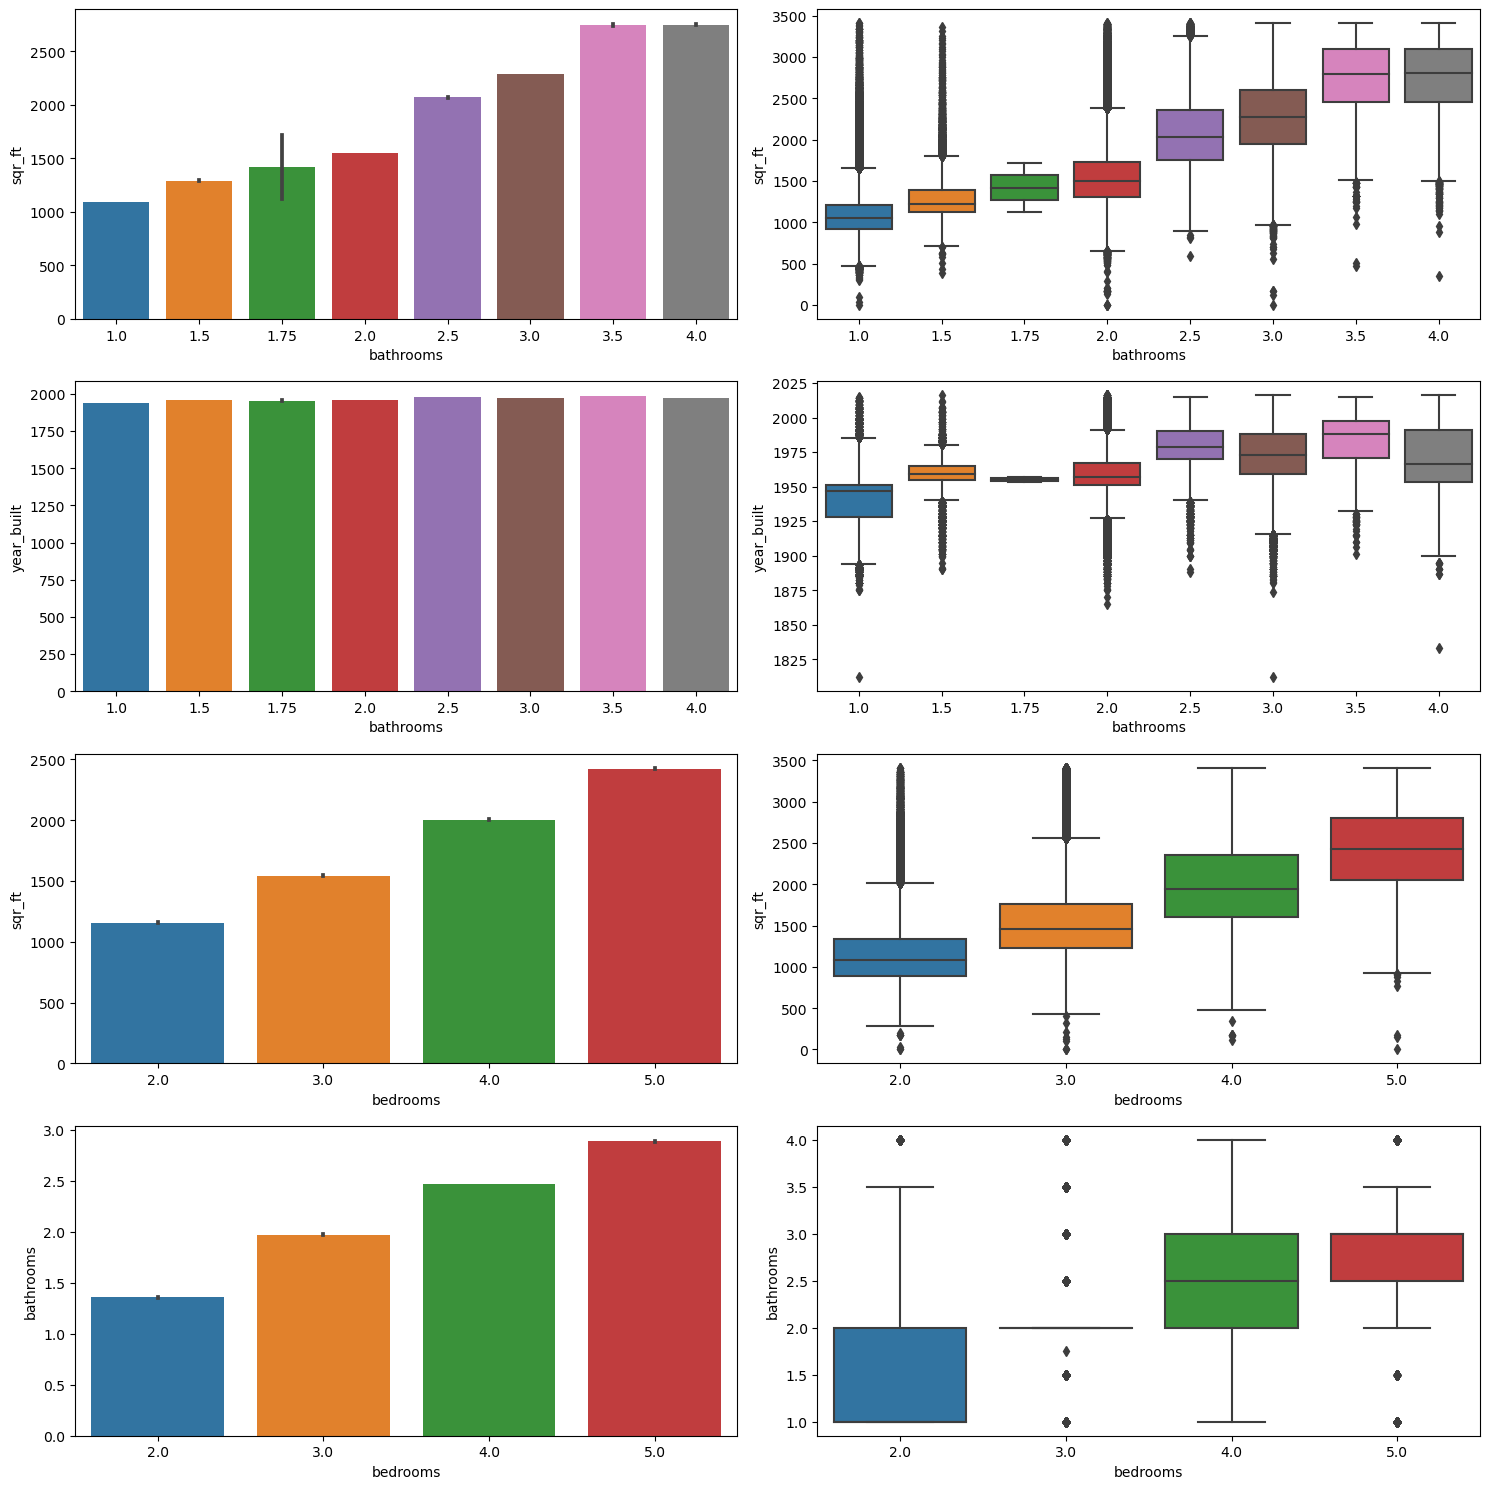

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(421)
sns.barplot(x='bathrooms', y='sqr_ft', data= train)

plt.subplot(422)
sns.boxplot(x='bathrooms', y='sqr_ft', data=train)

plt.subplot(423)
sns.barplot(x='bathrooms', y='year_built', data= train)

plt.subplot(424)
sns.boxplot(x='bathrooms', y='year_built', data=train)

plt.subplot(425)
sns.barplot(x='bedrooms', y='sqr_ft', data= train)

plt.subplot(426)
sns.boxplot(x='bedrooms', y='sqr_ft', data=train)

plt.subplot(427)
sns.barplot(x='bedrooms', y='bathrooms', data= train)

plt.subplot(428)
sns.boxplot(x='bedrooms', y='bathrooms', data=train)
plt.tight_layout()
plt.show()

##### bathroom x square feet
- In respect to the IQR, the more square feet a house contained, the more bathrooms they had.
- The 25% and 75% do not follow the same trend as the IQR.
    - There is no obvious trend for the 25% and 75%, I believe them to be outliers.

##### bathroom x year built
- no obvious trend

##### bedrooms x square feet
- In respect to the IQR, the more bedrooms a house contained, the more bathrooms the house had.
- The 25% and 75% do not follow the same trend as the IQR.
    - There is no obvious trend for the 25% and 75%, I believe them to be outliers.
    
##### bedrooms x bathrooms
- it appears the more bedrooms a house contains, the more bathrooms it contains.
        - this trend is not as obvious as bedroom x sqr ft, and bathrooms x sqr ft.

##### Based off the vizualizations, I will remove outliers and isolate the data to the IQR for the following: 
- tax_value x tax_amount
- bathroom x sqr_ft
- bedrooms x sqr_ft
- bedrooms x bathrooms

In [8]:
col_list = ['bedrooms', 'bathrooms', 'sqr_ft', 'tax_value', 'tax_amount']

def retrieve_IQR(df, col_list, k):
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [9]:
train = retrieve_IQR(train, col_list, 1.5)

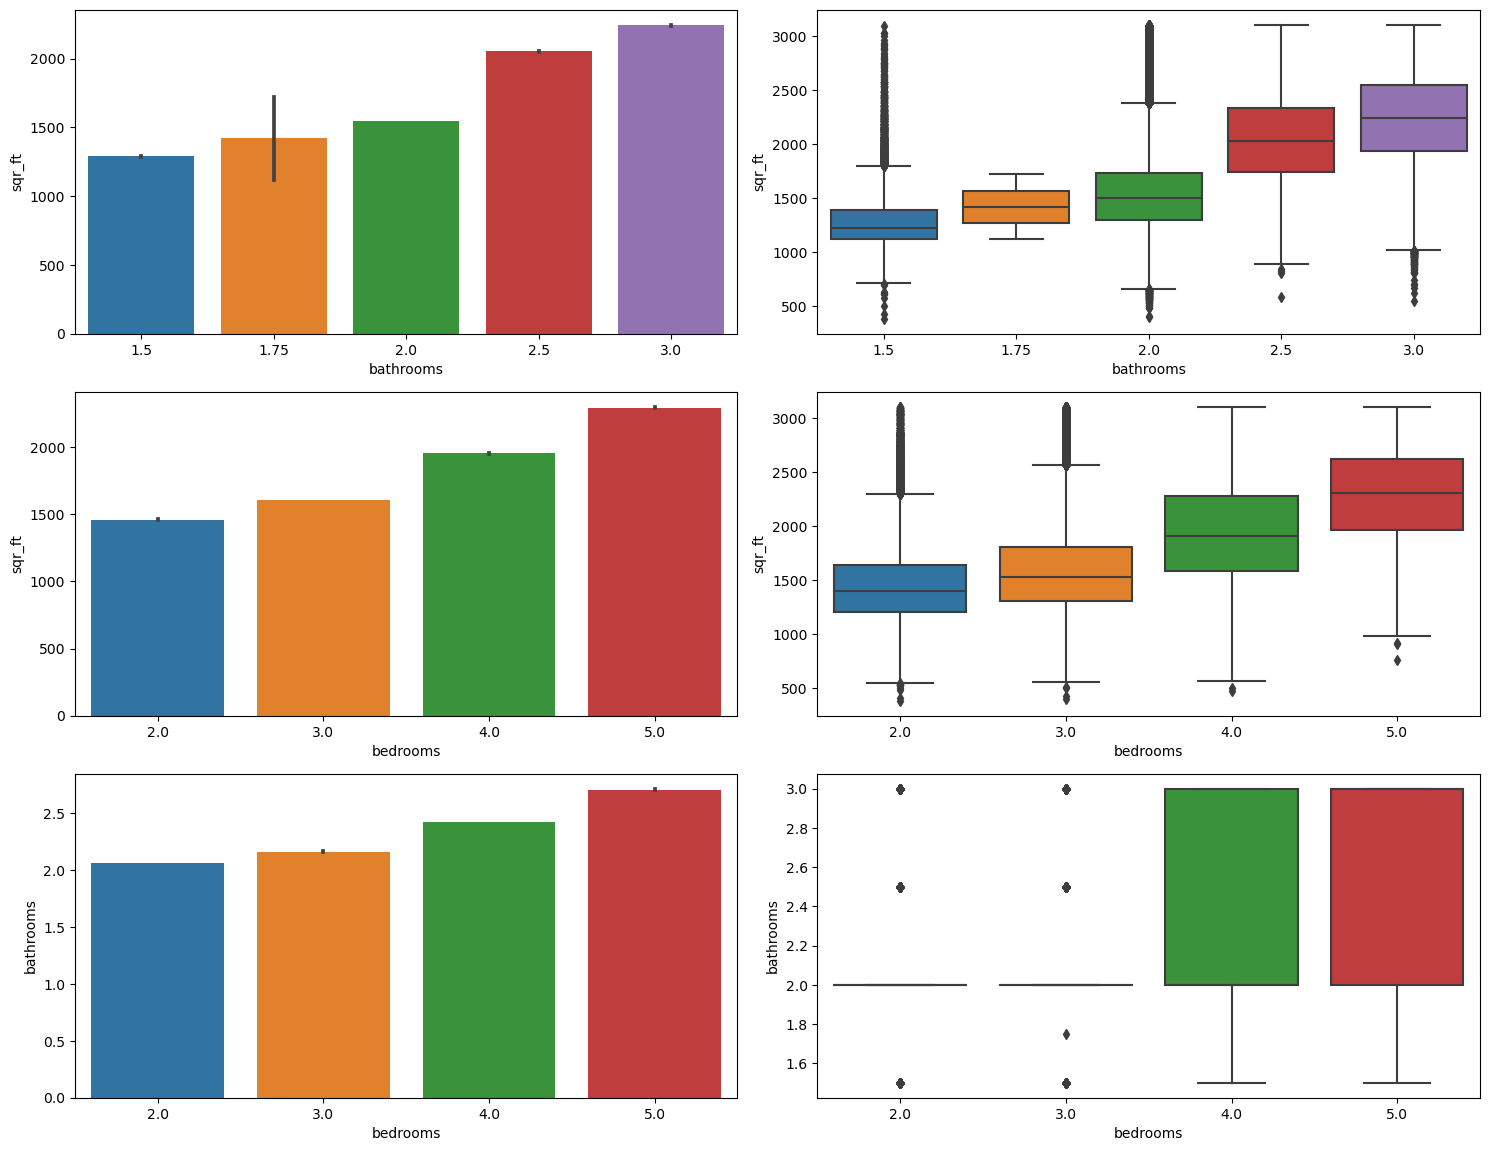

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(421)
sns.barplot(x='bathrooms', y='sqr_ft', data= train)

plt.subplot(422)
sns.boxplot(x='bathrooms', y='sqr_ft', data=train)

plt.subplot(423)
sns.barplot(x='bedrooms', y='sqr_ft', data= train)

plt.subplot(424)
sns.boxplot(x='bedrooms', y='sqr_ft', data=train)

plt.subplot(425)
sns.barplot(x='bedrooms', y='bathrooms', data= train)

plt.subplot(426)
sns.boxplot(x='bedrooms', y='bathrooms', data=train)
plt.tight_layout()
plt.show()

##### After removing outliers and isolating the data set the the IQR:

bathrooms x sqr_ft keeps its trend from earlier

bedrooms x sqr_ft also keeps its trend

bedrooms x bathrooms have no obvious trend

<Figure size 1500x1500 with 0 Axes>

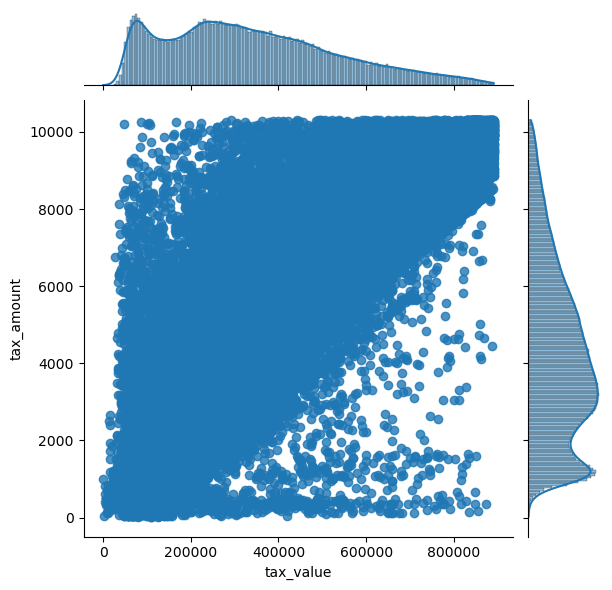

In [11]:
plt.figure(figsize=(15,15))
sns.jointplot(x="tax_value", y="tax_amount", data=train,  kind='reg')
plt.show()

##### After removing outliers and isolating the data to the IQR:

The trend for tax_value and tax_amount remains the same

##### Based of the IQR vizualizations I will continue to perform stats tests on the following:

- tax_value x tax_amount
- bathrooms x sqr_ft
- bedrooms x sqr_ft
- bedrooms x bathrooms

In [12]:
def hypothesis_test(x, y):
    α = 0.05
    r, p = stats.pearsonr(x, y)
    if p > α:
        print(f'P-value: {p} \nr-value: {r} \nI fail to reject the null hypothesis.')
    else:
        print(f'P-value: {p} \nr-value: {r} \nI reject the null hypothesis.')

##### tax_value x tax_amount
H$_0$: There is not a statistic relationship between tax_value and tax_amount

H$_a$: There is a statistic relationship between tax_value and tax_amount

In [13]:
hypothesis_test(train.tax_value, train.tax_amount)

P-value: 0.0 
r-value: 0.9674707312199871 
I reject the null hypothesis.


Take aways

- The lack of a p-value is sus.
- r-value indicated a strong linear correlation between tax value and tax amount. 
- I will model this using linear regression.

##### bathrooms x sqr_ft
H$_0$: There is not a statistic relationship between bathrooms and sqr_ft

H$_a$: There is a statistic relationship between bathrooms and sqr_ft

In [14]:
hypothesis_test(train.bathrooms, train.sqr_ft)

P-value: 0.0 
r-value: 0.6514903443702335 
I reject the null hypothesis.


Take aways

- Lack of p-value is sus
- r-value indicated a weak linear relationship
- I will model with linear regression

##### bedrooms x sqr_ft
H$_0$: There is not a statistic relationship between bedrooms and sqr_ft
H$_a$: There is a statistic relationship between bedrooms and sqr_ft

In [15]:
hypothesis_test(train.bedrooms, train.sqr_ft)

P-value: 0.0 
r-value: 0.4441550899870504 
I reject the null hypothesis.


Take aways

- Lack of a p-value is sus
- No linear relationship
- I may continue to modeling

##### bedrooms x bathrooms
H$_0$: There is not a statistic relationship between bedrooms and bathrooms
H$_a$: There is a statistic relationship between bedrooms and bathrooms

In [16]:
hypothesis_test(train.bedrooms, train.bathrooms)

P-value: 0.0 
r-value: 0.36426308175205463 
I reject the null hypothesis.


Take aways

- Lack of p-value is sus
- There is a weak negative linear regression
- I will model with linear regression.

##### Based off the statistic test, I will continue to modeling with

- tax_value x tax_amount

- bathroom x sqr_ft

In [21]:
X_train = train[['tax_amount']]
y_train = train.tax_value

X_validate = validate[['tax_amount']]
y_validate = validate.tax_value

X_test = test[['tax_amount']]
y_test = test.tax_value

In [22]:
# generate parameters, i.e. create model
ols_model = LinearRegression().fit(train[['tax_amount']], train.tax_value)

# compute predictions and add to original dataframe
train['yhat'] = ols_model.predict(train[['tax_amount']])
train.head()

,bedrooms,bathrooms,sqr_ft,tax_value,year_built,tax_amount,fips,zipcode,yhat
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0,96995.0,194747.540577
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0,96124.0,123274.314420
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0,96282.0,436079.897548
1948527,3.0,2.0,1988.0,68228.0,1973.0,1363.84,6111.0,97099.0,96822.687038
1896044,2.0,2.0,1382.0,579340.0,1939.0,7052.68,6037.0,96449.0,585248.393539


In [23]:
train['residuals'] = train.tax_value - train.yhat
train

,bedrooms,bathrooms,sqr_ft,tax_value,year_built,tax_amount,fips,zipcode,yhat,residuals
10057,4.0,2.0,1561.0,248240.0,1973.0,2504.40,6059.0,96995.0,194747.540577,53492.459423
2004970,3.0,2.0,1770.0,88390.0,1960.0,1671.93,6037.0,96124.0,123274.314420,-34884.314420
270959,3.0,2.0,1974.0,432268.0,1988.0,5315.27,6037.0,96282.0,436079.897548,-3811.897548
1948527,3.0,2.0,1988.0,68228.0,1973.0,1363.84,6111.0,97099.0,96822.687038,-28594.687038
1896044,2.0,2.0,1382.0,579340.0,1939.0,7052.68,6037.0,96449.0,585248.393539,-5908.393539
...,...,...,...,...,...,...,...,...,...,...
814662,3.0,2.0,1666.0,70783.0,1962.0,1088.07,6037.0,96524.0,73145.952048,-2362.952048
778998,2.0,2.0,1834.0,188991.0,1938.0,2549.24,6037.0,96531.0,198597.360344,-9606.360344
1993899,2.0,2.0,1150.0,116503.0,1988.0,2287.89,6037.0,97317.0,176158.680684,-59655.680684
1707759,4.0,2.0,1859.0,95008.0,1961.0,1463.61,6037.0,96489.0,105388.621875,-10380.621875


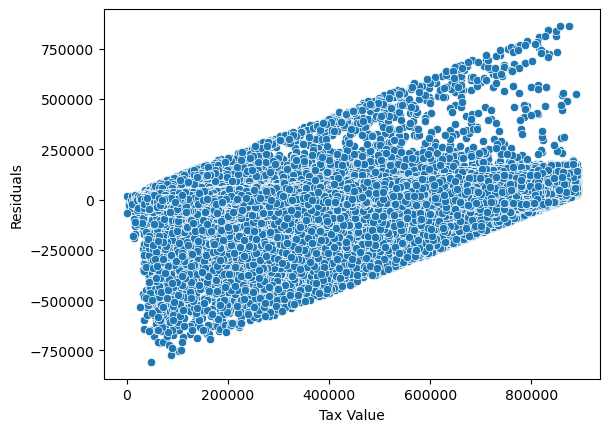

In [38]:
sns.scatterplot(data = train, x='tax_value', y = 'residuals')
plt.xlabel('Tax Value')
plt.ylabel('Residuals')
plt.show()

In [28]:
# residual squared = (y - yhat)^2
train['residual_squared'] = train.residuals**2

In [31]:
# Sum of Squared Errors = sum of squared residuals
SSE = sum(train.residual_squared)
# Mean Squared Error = mean of SSE
MSE = SSE/len(train)
# Root Mean Squared Error = sqrt of MSE
RMSE = MSE**.5
# Explained Sum of Squares = sum(predicted - (mean(actual)))
ESS = sum((train.yhat - train.tax_value.mean())**2)
# Total Sum of Squares = sum(actual - (mean(actual)))
# OR (TSS = ESS + SSE)
TSS = sum((train.tax_value - train.tax_value.mean())**2)
# Total Sum of Squares = sum(actual - (mean(actual)))
# OR (TSS = ESS + SSE)
TSS = sum((train.tax_value - train.tax_value.mean())**2)
# sum of squared errors
print(f"Sum of Squared Errors(SSE): {SSE:.8f}\n")
# mean squared error
print(f"Mean Squared Error(MSE): {MSE:.8f}\n")
# root mean squared error
print(f"Root Mean Squared Error(RMSE): {RMSE:.8f}\n")
# explained sum of squares
print(f"Explained Sum of Squares(ESS): {ESS:.8f}\n")
# total sum of squares
print(f"Total Sum of Squares(TSS): {TSS:.8f}\n")

Sum of Squared Errors(SSE): 1908458083456112.75000000

Mean Squared Error(MSE): 2433131194.93922186

Root Mean Squared Error(RMSE): 49326.77969358

Explained Sum of Squares(ESS): 27911020445326848.00000000

Total Sum of Squares(TSS): 29819478528786444.00000000



In [32]:
# create baseline
train['baseline'] = train['tax_value'].mean()
# baseline residual
train['baseline_residual'] = train.tax_value - train.baseline
# baseline residual squared 
train['baseline_residual_squared'] = train.baseline_residual**2
# baseline SSE
# Sum of Squared Errors = sum of squared residuals
SSE_baseline = sum(train.baseline_residual_squared)
# baseline MSE
# Mean Squared Error = mean of SSE
MSE_baseline = SSE_baseline/len(train)
# baseline RMSE
# Root Mean Squared Error = sqrt of MSE
RMSE_baseline = MSE_baseline**.5

In [40]:
# baseline sum of squared errors
print(f"Baseline Sum of Squared Errors(SSE): {SSE_baseline:.8f}\n")
# baseline mean squared error
print(f"Baseline Mean Squared Error(MSE): {MSE_baseline:.8f}\n")
# baseline root mean squared error
print(f"Baseline Root Mean Squared Error(RMSE): {RMSE_baseline:.8f}\n")

Baseline Sum of Squared Errors(SSE): 29819478528786444.00000000

Baseline Mean Squared Error(MSE): 38017446678.11516571

Baseline Root Mean Squared Error(RMSE): 194980.63154610



In [36]:
if SSE < SSE_baseline:
    print('The model performs better than baseline')
else:
    print('The model does not perform better than the baseline')

The model performs better than baseline


### Conclusion:

I have no diffinitive conclusion about the data. I am confident in the relationship between tax_value and tax_amount, as well as the relationship between bathroom and sqr_ft. With more time I will be able to produce models for bathrooms and sqr_ft and build at least one other model for tax value and tax amount. After comparing models I can then move into validation and testing the best performing models. I would also like to look for errors and clean up the work I have completed and pin-point state and county locations for properties.